In [18]:
%pip install text2emotion
%pip install stop_words

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [19]:
import sys
from os import path
from os.path import exists
import text2emotion as te
import pandas as pd
import json
from collections import Counter
import matplotlib.pyplot as plt
import sagemaker
import boto3
import csv
import nltk
from stop_words import get_stop_words
import re
stop_words = get_stop_words('en')

## Get data
* Get teacher feedback from s3 bucket

In [30]:
role = sagemaker.get_execution_role()

s3 = boto3.resource('s3')

bucket = 'ad440-mpg-floop-export-storage'

obj = s3.Object(bucket, 'auto-floop-s3-export3-sagemaker.json')

s3_client = boto3.client('s3')
client = boto3.client('sagemaker')
data = json.load(obj.get()['Body'])
print(data[0])
len(data)

[{'Text': 'Eleborate and Write conclusion   3marks', 'uid': 'T'}]


3831

In [21]:
# Get few lines from file for sample
dataList=[]
for i in range(3000):
    dataList.append(data[i])

In [22]:
# Create array of the sample sentences to analyze
sentences=[]

# switch dataList to data for get all data
for x in dataList:
    for y in x:       
        sentences.append(y['Text'])
print(sentences)

['Eleborate and Write conclusion   3marks', 'If the temperature in a pond is lower, then the dissolved oxygen will be higher because gas escapes more readily in liquids at high temperature due to increased movement of kinetic energy (= increased movement of molecules)', 'Maybe there is a need to be clear about why they need large sums = e.g. think about the cost of the state of the art machinery that {{NAME}} uses in his factories.', 'More details.  A lot happened.', 'iu98fgxv bm,÷\n"', 's-v', 'pronoun problem', '{{NAME}}, your handwriting is hard to read...please try printing...', 'What is this word?', 'Procedure', '{{ORGANIZATION}}', 'Nice paragraph!', 'This title needs to have the units (mL).', "Yes ma'am", 'Missing average line', 'No im not', 'Its at the end next to {{NAME}}', 'More treatment and effects needed.', 'We had a twelve word limit and  could and any more the the slide. Also, by overview, the is just an', "Your hard work on this poem shows, {{NAME}}.  You've met our goals

In [23]:
# Add sentences to dataframe
df = pd.DataFrame(sentences)
df.columns=['Sentence']
df.head()

,Sentence
0,Eleborate and Write conclusion 3marks
1,"If the temperature in a pond is lower, then th..."
2,Maybe there is a need to be clear about why th...
3,More details. A lot happened.
4,"iu98fgxv bm,÷\n"""


## Clean the dataset
* remove unnecessary stop words, punctuation and change the data to lower case. 

In [24]:
def remove_stopWords(s):
    s = ' '.join(word for word in s.split() if word not in stop_words)
    return s


# Clean up sentences
def clean_df(df):
    df.loc[:,"Sentence"] = df.Sentence.apply(lambda x : str.lower(x)) # convert to lower case
    df.loc[:,"Sentence"] = df.Sentence.apply(lambda x : " ".join(re.findall('[\w]+',x))) # remove punctuation and numbers
    df.loc[:,"Sentence"] = df.Sentence.apply(lambda x : remove_stopWords(x)) # remove stop words
    return df

clean_df(df)
df.head()

,Sentence
0,eleborate write conclusion 3marks
1,temperature pond lower dissolved oxygen will h...
2,maybe need clear need large sums e g think cos...
3,details lot happened
4,iu98fgxv bm


## Find emotion per sentence
* We are using the text2emotion library for determining the emotion per sentence by matching certain words with emotion.

In [25]:
def isEmotion(sentence):
    emotions = te.get_emotion(sentence)
    max_val = max(emotions.values())
    if max_val == 0:
        return 'none'
    else:
        # return highest value emotion
        emotion = max(emotions, key=lambda key: emotions[key])
        return emotion

In [26]:
# Determine emotion for each sentence
emotionList=[]
score=[]
for i in sentences:
    emotionList.append(isEmotion(i))
    
countEmotions = Counter(emotionList)

## Add emotion to each sentence

In [27]:
# Data frame for original sentence and emotion analyzed
df = pd.DataFrame(list(zip(sentences, emotionList)),columns=['Sentence', 'Emotion'])
df.head()

,Sentence,Emotion
0,Eleborate and Write conclusion 3marks,none
1,"If the temperature in a pond is lower, then th...",Fear
2,Maybe there is a need to be clear about why th...,Surprise
3,More details. A lot happened.,Sad
4,"iu98fgxv bm,÷\n""",none


### Export analysis to csv for training and deploying the model.

In [28]:
df.to_csv('sentenceEmotion.csv')

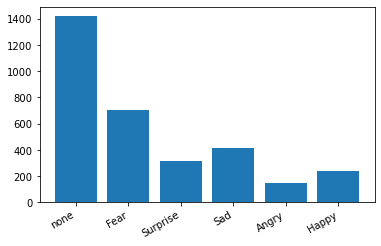

In [29]:
fig, axl = plt.subplots()
axl.bar(countEmotions.keys(), countEmotions.values())
fig.autofmt_xdate()
plt.show()